In [ ]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, classification_report,confusion_matrix

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction import DictVectorizer

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, ParameterGrid

: 

In [2]:
ufc_data = pd.read_csv('ufc-master.csv')

#add name of winner for each match
ufc_data['WinnerName'] = ufc_data.apply(lambda x: x['BlueFighter'] if x['Winner'] == 'Blue' else x['RedFighter'], axis = 1)

ufc_data.head()

,RedFighter,BlueFighter,RedOdds,BlueOdds,RedExpectedValue,BlueExpectedValue,Date,Location,Country,Winner,...,FinishRound,FinishRoundTime,TotalFightTimeSecs,RedDecOdds,BlueDecOdds,RSubOdds,BSubOdds,RKOOdds,BKOOdds,WinnerName
0,Neil Magny,Carlos Prates,550.0,-800.0,550.0000,12.5000,2024-11-09,"Las Vegas, Nevada, USA",USA,Blue,...,1.0,4:50,290.0,1100.0,800.0,1600.0,800.0,2000.0,-400.0,Carlos Prates
1,Gerald Meerschaert,Reinier de Ridder,250.0,-310.0,250.0000,32.2581,2024-11-09,"Las Vegas, Nevada, USA",USA,Blue,...,3.0,1:44,704.0,700.0,200.0,600.0,165.0,1400.0,450.0,Reinier de Ridder
2,Gaston Bolanos,Cortavious Romious,205.0,-250.0,205.0000,40.0000,2024-11-09,"Las Vegas, Nevada, USA",USA,Red,...,3.0,5:00,900.0,550.0,275.0,3000.0,165.0,380.0,450.0,Gaston Bolanos
3,Luana Pinheiro,Gillian Robertson,360.0,-470.0,360.0000,21.2766,2024-11-09,"Las Vegas, Nevada, USA",USA,Blue,...,3.0,5:00,900.0,600.0,250.0,2200.0,110.0,900.0,500.0,Gillian Robertson
4,Mansur Abdul-Malik,Dusko Todorovic,-485.0,370.0,20.6186,370.0000,2024-11-09,"Las Vegas, Nevada, USA",USA,Red,...,1.0,2:44,164.0,600.0,NaN,800.0,NaN,-250.0,NaN,Mansur Abdul-Malik


In [3]:
label_enc = LabelEncoder()
ufc_data['RedStance'] = label_enc.fit_transform(ufc_data['RedStance'])
ufc_data['BlueStance'] = label_enc.fit_transform(ufc_data['BlueStance'])
ufc_data['WeightClass'] = label_enc.fit_transform(ufc_data['WeightClass'])

#assigning each name to a number so that the model will be able to quantify the results correctly
fighters = pd.concat([ufc_data['RedFighter'],ufc_data['BlueFighter']]).unique()
ids = range(1, len(fighters) + 1)

f_id = pd.DataFrame({'ids': ids, 'name': fighters})
id_dict = dict(zip(fighters, ids))
f_id.head()

,ids,name
0,1,Neil Magny
1,2,Gerald Meerschaert
2,3,Gaston Bolanos
3,4,Luana Pinheiro
4,5,Mansur Abdul-Malik


In [4]:
ufc_data['RedFighter'].replace(id_dict, inplace=True)
ufc_data['BlueFighter'].replace(id_dict, inplace=True)
ufc_data['WinnerName'].replace(id_dict, inplace=True)
ufc_data.head()

,RedFighter,BlueFighter,RedOdds,BlueOdds,RedExpectedValue,BlueExpectedValue,Date,Location,Country,Winner,...,FinishRound,FinishRoundTime,TotalFightTimeSecs,RedDecOdds,BlueDecOdds,RSubOdds,BSubOdds,RKOOdds,BKOOdds,WinnerName
0,1,1656,550.0,-800.0,550.0000,12.5000,2024-11-09,"Las Vegas, Nevada, USA",USA,Blue,...,1.0,4:50,290.0,1100.0,800.0,1600.0,800.0,2000.0,-400.0,1656
1,2,1657,250.0,-310.0,250.0000,32.2581,2024-11-09,"Las Vegas, Nevada, USA",USA,Blue,...,3.0,1:44,704.0,700.0,200.0,600.0,165.0,1400.0,450.0,1657
2,3,1658,205.0,-250.0,205.0000,40.0000,2024-11-09,"Las Vegas, Nevada, USA",USA,Red,...,3.0,5:00,900.0,550.0,275.0,3000.0,165.0,380.0,450.0,3
3,4,351,360.0,-470.0,360.0000,21.2766,2024-11-09,"Las Vegas, Nevada, USA",USA,Blue,...,3.0,5:00,900.0,600.0,250.0,2200.0,110.0,900.0,500.0,351
4,5,730,-485.0,370.0,20.6186,370.0000,2024-11-09,"Las Vegas, Nevada, USA",USA,Red,...,1.0,2:44,164.0,600.0,NaN,800.0,NaN,-250.0,NaN,5


In [5]:
def american_to_decimal(odds):
    if odds > 0:
        return odds / 100 + 1
    else:
        return 100 / abs(odds) + 1

ufc_data['red_decimal_odds'] = ufc_data['RedOdds'].apply(american_to_decimal)
ufc_data['blue_decimal_odds'] = ufc_data['BlueOdds'].apply(american_to_decimal)

ufc_data['odds_difference'] = ufc_data['red_decimal_odds'] - ufc_data['blue_decimal_odds']
ufc_data.head()

,RedFighter,BlueFighter,RedOdds,BlueOdds,RedExpectedValue,BlueExpectedValue,Date,Location,Country,Winner,...,RedDecOdds,BlueDecOdds,RSubOdds,BSubOdds,RKOOdds,BKOOdds,WinnerName,red_decimal_odds,blue_decimal_odds,odds_difference
0,1,1656,550.0,-800.0,550.0000,12.5000,2024-11-09,"Las Vegas, Nevada, USA",USA,Blue,...,1100.0,800.0,1600.0,800.0,2000.0,-400.0,1656,6.500000,1.125000,5.375000
1,2,1657,250.0,-310.0,250.0000,32.2581,2024-11-09,"Las Vegas, Nevada, USA",USA,Blue,...,700.0,200.0,600.0,165.0,1400.0,450.0,1657,3.500000,1.322581,2.177419
2,3,1658,205.0,-250.0,205.0000,40.0000,2024-11-09,"Las Vegas, Nevada, USA",USA,Red,...,550.0,275.0,3000.0,165.0,380.0,450.0,3,3.050000,1.400000,1.650000
3,4,351,360.0,-470.0,360.0000,21.2766,2024-11-09,"Las Vegas, Nevada, USA",USA,Blue,...,600.0,250.0,2200.0,110.0,900.0,500.0,351,4.600000,1.212766,3.387234
4,5,730,-485.0,370.0,20.6186,370.0000,2024-11-09,"Las Vegas, Nevada, USA",USA,Red,...,600.0,NaN,800.0,NaN,-250.0,NaN,5,1.206186,4.700000,-3.493814


In [6]:
#split data into training and testing sets

#interesting_columns = ['RedFighter', 'BlueFighter', 'RedOdds', 'BlueOdds', 'BlueWins', 'RedWins', 'BlueStance', 'RedStance', 'SigStrDif', 'AvgTDDif', 'WinnerName']

#copy = ufc_data.copy()
#copy = copy[interesting_columns].dropna()

#Y = copy['WinnerName']
#copy.drop('WinnerName', axis=1, inplace=True)
#X = copy

#X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.25, shuffle=True) 

In [7]:
sett = ufc_data[['RedOdds', 'BlueOdds','LossDif','SigStrDif','ReachDif','AvgTDDif','KODif','SubDif', 'WeightClass', 'Winner']].dropna()
X = sett[['RedOdds', 'BlueOdds','LossDif','SigStrDif','ReachDif','AvgTDDif','KODif','SubDif', 'WeightClass']]
Y = sett['Winner'] 

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.25, shuffle=True) 
sett.shape

(6253, 10)

In [8]:
mlp = MLPClassifier(hidden_layer_sizes=(32,16,16), activation='relu', max_iter=300, random_state=42)
mlp.fit(X_train, y_train)

y_pred_mlp = mlp.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_mlp)
 
accuracy

0.6624040920716112

In [9]:
#rfc = RandomForestClassifier(criterion='entropy', max_depth=10, random_state=42)
#rfc.fit(X_train, y_train)

#y_pred_rfc = rfc.predict(X_test)
#accuracy = accuracy_score(y_test, y_pred_rfc)

#accuracy

In [10]:
#dtc = DecisionTreeClassifier(criterion='entropy', random_state=42)
#dtc.fit(X_train, y_train)

#y_pred_dtc = dtc.predict(X_test)
#accuracy = accuracy_score(y_test, y_pred_dtc)

#accuracy

Notes:

- Out of the three classifiers, it seems that Random Forests or a Neural Network work best.

- Attempting to predict using WinnerName as Y gives very low accuracy below 5%

In [11]:
upcoming = pd.read_csv('upcoming.csv')
upcoming['WeightClass'] = label_enc.fit_transform(upcoming['WeightClass'])

#match between Weidman and Anders was cancelled
december_match = upcoming.loc[6, ['RedOdds', 'BlueOdds','LossDif','SigStrDif','ReachDif','AvgTDDif','KODif','SubDif', 'WeightClass']]
upcoming.drop(6, inplace=True)
upcoming

,RedFighter,BlueFighter,RedOdds,BlueOdds,RedExpectedValue,BlueExpectedValue,Date,Location,Country,Winner,...,FinishDetails,FinishRound,FinishRoundTime,TotalFightTimeSecs,RedDecOdds,BlueDecOdds,RSubOdds,BSubOdds,RKOOdds,BKOOdds
0,Jon Jones,Stipe Miocic,-625,455,16.0000,455.0000,2024-11-16,"New York City, New York, USA",USA,NaN,...,NaN,NaN,NaN,NaN,400,1400,200,3500,120,700
1,Charles Oliveira,Michael Chandler,-258,210,38.7597,210.0000,2024-11-16,"New York City, New York, USA",USA,NaN,...,NaN,NaN,NaN,NaN,1200,1100,130,900,215,380
2,Bo Nickal,Paul Craig,-1200,750,8.3333,750.0000,2024-11-16,"New York City, New York, USA",USA,NaN,...,NaN,NaN,NaN,NaN,700,3000,175,1400,-150,3000
3,Viviane Araujo,Karine Silva,240,-298,240.0000,33.5570,2024-11-16,"New York City, New York, USA",USA,NaN,...,NaN,NaN,NaN,NaN,300,100,2000,300,2000,750
4,Mauricio Ruffy,James Llontop,-900,600,11.1111,600.0000,2024-11-16,"New York City, New York, USA",USA,NaN,...,NaN,NaN,NaN,NaN,180,1200,800,3500,-150,1800
5,Jonathan Martinez,Marcus McGhee,114,-135,114.0000,74.0741,2024-11-16,"New York City, New York, USA",USA,NaN,...,NaN,NaN,NaN,NaN,215,250,1400,1400,500,225
7,Jim Miller,Damon Jackson,185,-225,185.0000,44.4444,2024-11-16,"New York City, New York, USA",USA,NaN,...,NaN,NaN,NaN,NaN,550,130,900,400,500,500
8,David Onama,Roberto Romero,-1350,800,7.4074,800.0000,2024-11-16,"New York City, New York, USA",USA,NaN,...,NaN,NaN,NaN,NaN,275,1400,275,4000,-120,2200
9,Marcin Tybura,Jhonata Diniz,-115,-105,86.9565,95.2381,2024-11-16,"New York City, New York, USA",USA,NaN,...,NaN,NaN,NaN,NaN,350,650,300,2200,450,165
10,Mickey Gall,Ramiz Brahimaj,-166,140,60.2410,140.0000,2024-11-16,"New York City, New York, USA",USA,NaN,...,NaN,NaN,NaN,NaN,180,300,380,550,450,1100


In [12]:
#manually adding in the Winner for the upcoming dataset according to https://www.ufc.com/event/ufc-309
winners = ['Red', 'Red', 'Red', 'Red', 'Red', 'Blue', 'Red', 'Red', 'Red', 'Blue', 'Blue', 'Blue']
upcoming['Winner'] = winners
upcoming

,RedFighter,BlueFighter,RedOdds,BlueOdds,RedExpectedValue,BlueExpectedValue,Date,Location,Country,Winner,...,FinishDetails,FinishRound,FinishRoundTime,TotalFightTimeSecs,RedDecOdds,BlueDecOdds,RSubOdds,BSubOdds,RKOOdds,BKOOdds
0,Jon Jones,Stipe Miocic,-625,455,16.0000,455.0000,2024-11-16,"New York City, New York, USA",USA,Red,...,NaN,NaN,NaN,NaN,400,1400,200,3500,120,700
1,Charles Oliveira,Michael Chandler,-258,210,38.7597,210.0000,2024-11-16,"New York City, New York, USA",USA,Red,...,NaN,NaN,NaN,NaN,1200,1100,130,900,215,380
2,Bo Nickal,Paul Craig,-1200,750,8.3333,750.0000,2024-11-16,"New York City, New York, USA",USA,Red,...,NaN,NaN,NaN,NaN,700,3000,175,1400,-150,3000
3,Viviane Araujo,Karine Silva,240,-298,240.0000,33.5570,2024-11-16,"New York City, New York, USA",USA,Red,...,NaN,NaN,NaN,NaN,300,100,2000,300,2000,750
4,Mauricio Ruffy,James Llontop,-900,600,11.1111,600.0000,2024-11-16,"New York City, New York, USA",USA,Red,...,NaN,NaN,NaN,NaN,180,1200,800,3500,-150,1800
5,Jonathan Martinez,Marcus McGhee,114,-135,114.0000,74.0741,2024-11-16,"New York City, New York, USA",USA,Blue,...,NaN,NaN,NaN,NaN,215,250,1400,1400,500,225
7,Jim Miller,Damon Jackson,185,-225,185.0000,44.4444,2024-11-16,"New York City, New York, USA",USA,Red,...,NaN,NaN,NaN,NaN,550,130,900,400,500,500
8,David Onama,Roberto Romero,-1350,800,7.4074,800.0000,2024-11-16,"New York City, New York, USA",USA,Red,...,NaN,NaN,NaN,NaN,275,1400,275,4000,-120,2200
9,Marcin Tybura,Jhonata Diniz,-115,-105,86.9565,95.2381,2024-11-16,"New York City, New York, USA",USA,Red,...,NaN,NaN,NaN,NaN,350,650,300,2200,450,165
10,Mickey Gall,Ramiz Brahimaj,-166,140,60.2410,140.0000,2024-11-16,"New York City, New York, USA",USA,Blue,...,NaN,NaN,NaN,NaN,180,300,380,550,450,1100


In [13]:
x_upc = upcoming[['RedOdds', 'BlueOdds','LossDif','SigStrDif','ReachDif','AvgTDDif','KODif','SubDif', 'WeightClass']]

upcoming_pred = mlp.predict(x_upc)
mlp_accuracy = accuracy_score(winners, upcoming_pred)

# rfc_pred = rfc.predict(x_upc)
# rfc_accuracy = accuracy_score(winners, rfc_pred)

# dtc_pred = dtc.predict(x_upc)
# dtc_accuracy = accuracy_score(winners, dtc_pred)

print(f"MLP Test Accuracy for recent matches: {mlp_accuracy * 100:.2f}%")
# print(f"RFC Test Accuracy for recent matches: {rfc_accuracy * 100:.2f}%")
# print(f"DTC Test Accuracy for recent matches: {dtc_accuracy * 100:.2f}%")

MLP Test Accuracy for recent matches: 66.67%


In [14]:
upcoming['Predictions'] = upcoming_pred
predictions = upcoming.apply(lambda x: x['BlueFighter'] if x['Predictions'] == 'Blue' else x['RedFighter'], axis=1)
actual = upcoming.apply(lambda x: x['BlueFighter'] if x['Winner'] == 'Blue' else x['RedFighter'], axis=1)

comparison = pd.DataFrame({'model_predictions': predictions, 'actual_results': actual})
comparison

,model_predictions,actual_results
0,Jon Jones,Jon Jones
1,Charles Oliveira,Charles Oliveira
2,Bo Nickal,Bo Nickal
3,Karine Silva,Viviane Araujo
4,Mauricio Ruffy,Mauricio Ruffy
5,Marcus McGhee,Marcus McGhee
7,Damon Jackson,Jim Miller
8,David Onama,David Onama
9,Marcin Tybura,Marcin Tybura
10,Mickey Gall,Ramiz Brahimaj


In [15]:
#prediction for Dec. 7
mlp.predict(december_match.to_numpy().reshape(1, -1))

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


array(['Red'], dtype='<U4')

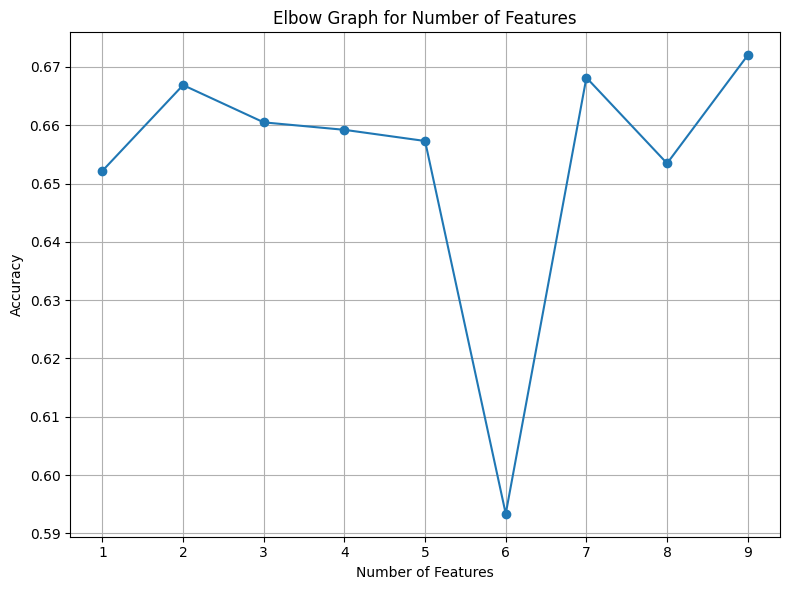

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

feature_counts = range(1, X.shape[1] + 1)  # Test with 1 to all features
accuracies = []

# Train and evaluate models with increasing number of features
for count in feature_counts:
    # Select the first 'count' features
    X_subset = X.iloc[:, :count]
    
    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X_subset, Y, test_size=0.25, shuffle=True)
    
    # Train the model
    mlp = MLPClassifier(hidden_layer_sizes=(32, 16, 16), activation='relu', max_iter=300, random_state=42)
    mlp.fit(X_train, y_train)
    
    # Evaluate the model
    y_pred = mlp.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Plot the elbow graph
plt.figure(figsize=(8, 6))
plt.plot(feature_counts, accuracies, marker='o')
plt.title("Elbow Graph for Number of Features")
plt.xlabel("Number of Features")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()


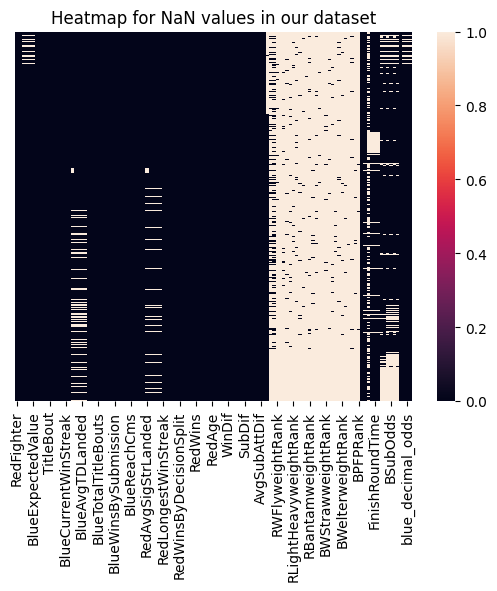

In [17]:
sns.heatmap(ufc_data.isnull(), yticklabels=False)
plt.title("Heatmap for NaN values in our dataset")
plt.show()

In [18]:
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Use the same code you already have for data preprocessing and model training.
# Assuming `mlp` is your trained MLP model and you've already split the data.

def predict_winner_terminal():
    print("Enter the following features for the fighters:")
    
    try:
        red_odds = float(input("Fighter 1 Odds: "))
        blue_odds = float(input("Fighter 2 Odds: "))
        loss_dif = float(input("Loss Difference(Fighter 1 - Fighter 2): "))
        sig_str_dif = float(input("Significant Strikes Difference(Fighter 1 - Fighter 2): "))
        reach_dif = float(input("Reach Difference(Fighter 1 - Fighter 2): "))
        avg_td_dif = float(input("Average Takedown Difference(Fighter 1 - Fighter 2): "))
        ko_dif = float(input("Knockout Difference(Fighter 1 - Fighter 2): "))
        sub_dif = float(input("Submission Difference(Fighter 1 - Fighter 2): "))
        weight_class = int(input("Weight Class (as an integer): "))

        # Create the feature array
        features = np.array([[red_odds, blue_odds, loss_dif, sig_str_dif, reach_dif, avg_td_dif, ko_dif, sub_dif, weight_class]])
        
        # Predict the winner
        prediction = mlp.predict(features)
        winner = "Fighter 1" if prediction[0] == "Red" else "Fighter 2"

        print(f"The predicted winner is: {winner}")

    except ValueError:
        print("Invalid input. Please enter numeric values where required.")

# Run the function
if __name__ == "__main__":
    predict_winner_terminal()


Enter the following features for the fighters:
The predicted winner is: Fighter 2
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5a713994-b4e1-47cc-89fe-2b6d51a0ee77' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>